In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.utils import check_array, safe_indexing, sparsefuncs_fast, check_X_y, check_random_state
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse
from sklearn.neighbors import NearestNeighbors
from sklearn.base import clone
from numbers import Integral
from sklearn.svm import SVC
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, SMOTENC, SVMSMOTE
import os
# import missingpy as missingpy
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold
import pickle
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

# Set folder paths for outputs

In [2]:
os.chdir('..')
REPO_ROOT = Path(os.getcwd())
DATA = Path(REPO_ROOT / 'data')
MODELS = Path(REPO_ROOT / 'model')
REPORTS = Path(REPO_ROOT / 'reports' / 'forest 26')

# Read the file

In [3]:
df = pd.read_csv(DATA / 'covtype.data.gz', compression='gzip', header=None, sep=',', quotechar='"', error_bad_lines=False)

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [5]:
## one-hot encode categorical variables
soil_colname = []
for i in range(40):
    soil_colname.append('soil{}'.format(i))
wild_colname = []
for i in range(4):
    wild_colname.append('wild{}'.format(i))


In [6]:
cont_columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
             'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
              'Horizontal_Distance_To_Fire_Points']

In [7]:
total_columns = []
total_columns.extend(cont_columns)
total_columns.extend(wild_colname)
total_columns.extend(soil_colname)
total_columns.extend(['Cover_Type'])
df.columns = total_columns

In [8]:
df.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,soil31,soil32,soil33,soil34,soil35,soil36,soil37,soil38,soil39,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
df.shape

(581012, 55)

In [11]:
df.isnull().sum()

Elevation                             0
Aspect                                0
Slope                                 0
Horizontal_Distance_To_Hydrology      0
Vertical_Distance_To_Hydrology        0
Horizontal_Distance_To_Roadways       0
Hillshade_9am                         0
Hillshade_Noon                        0
Hillshade_3pm                         0
Horizontal_Distance_To_Fire_Points    0
wild0                                 0
wild1                                 0
wild2                                 0
wild3                                 0
soil0                                 0
soil1                                 0
soil2                                 0
soil3                                 0
soil4                                 0
soil5                                 0
soil6                                 0
soil7                                 0
soil8                                 0
soil9                                 0
soil10                                0


In [12]:
Counter(df.Cover_Type)

Counter({5: 9493, 2: 283301, 1: 211840, 7: 20510, 3: 35754, 6: 17367, 4: 2747})

### There are 7 target labels of the dtaset- 2 and 6 are randomly chosen among them(since this algorith is built for binary classification)

In [13]:
df = df.loc[df['Cover_Type'].isin([2, 6])]
df['Cover_Type'].replace({2: 0, 6: 1},inplace = True)

In [14]:
Counter(df.Cover_Type)

Counter({0: 283301, 1: 17367})

In [15]:
df_feature= df.drop('Cover_Type',1)
df_target= df[['Cover_Type']]
df_feature.index = pd.RangeIndex(len(df_feature.index))
df_target.index = pd.RangeIndex(len(df_target.index))

In [16]:
col_list = list(df_feature.columns)

In [17]:
## Apply standard scaler on the features , so that euclidean distance calculation in SMOTE is not biased
sc = StandardScaler()
df_feature = sc.fit_transform(df_feature)
df_feature = pd.DataFrame(df_feature, index=range(df_feature.shape[0]),
                          columns=col_list)

In [18]:
df_feature.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,soil30,soil31,soil32,soil33,soil34,soil35,soil36,soil37,soil38,soil39
0,-0.399128,-0.134249,-0.670227,-0.023920,0.336208,0.515973,0.822781,0.705092,-0.225044,2.841905,...,-0.214896,-0.331416,-0.306676,-0.069516,-0.006318,-0.01182,0.0,-0.049672,-0.034527,-0.033248
1,-0.485349,0.011818,0.568870,-0.148768,1.267114,0.460084,0.976798,0.705092,-0.577962,2.905575,...,-0.214896,-0.331416,-0.306676,-0.069516,-0.006318,-0.01182,0.0,-0.049672,-0.034527,-0.033248
2,-1.420161,-0.198153,-1.083259,0.129739,-1.068933,-1.417154,0.668764,0.653128,-0.089306,2.778234,...,-0.214896,-0.331416,-0.306676,-0.069516,-0.006318,-0.01182,0.0,-0.049672,-0.034527,-0.033248
3,-0.027019,-0.024699,-0.394872,0.470671,-0.348798,1.803275,0.822781,0.809022,-0.197896,1.377488,...,-0.214896,-0.331416,-0.306676,-0.069516,-0.006318,-0.01182,0.0,-0.049672,-0.034527,-0.033248
4,-0.680480,-0.179895,1.119580,-0.590539,0.406465,0.537707,1.361841,-0.022415,-1.392390,2.820681,...,-0.214896,-0.331416,-0.306676,-0.069516,-0.006318,-0.01182,0.0,-0.049672,-0.034527,-0.033248


# Create helper functions

In [19]:
## evaluate function generates the classification report of the loaded model based on the list of x and y values

def evaluate(x, y, threshold):
    x = np.array(x)
    y = np.ravel(y)
    pred = (loaded_model.predict_proba(x)[:,1] >= threshold).astype(bool)
    print(pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted']))
    print(classification_report(y, pred,digits=4))
    return None;

## Split the data to be 2-fold cross-validated
kfold = StratifiedKFold(n_splits=2, random_state=42, shuffle=False)
#randomforest model - hyperparameter tuning using grid search
param_grid = {
'max_depth': [11], 'max_features': [6],
'min_samples_leaf': [3], 'min_samples_split': [3], 'n_estimators': [500]
}# Create a base model
param_grid = {'randomforestclassifier__' + key: param_grid[key] for key in param_grid}


## generate_curves function creates ROC-AUC and PR-AUC curve of the loaded model and compare that wth the random classifier

def generate_curves(filename, X_test, y_test):   

    f = plt.figure(figsize=(10,4))
    ax1 = f.add_subplot(121)
    loaded_model_old = pickle.load(open(filename, 'rb'))

    test_prob_old = loaded_model_old.predict_proba(X_test)[:, 1]

    
    fpr_old, tpr_old, _ = roc_curve(y_test,  test_prob_old)
    roc_auc_old = roc_auc_score(y_test,  test_prob_old)
    ax1.plot([0, 1], [0, 1], linestyle='--',label ='random, auc = %.4f'% 0.5, c = 'blue')
    ax1.plot(fpr_old, tpr_old ,label ='smote, auc = %.4f'% roc_auc_old, c= 'green')
    
    ax1.legend(loc=4)

    ax1.set_title('ROC curve' ,fontsize=16)
    ax1.set_ylabel('True Positive Rate',fontsize=14)
    ax1.set_xlabel('False Positive Rate',fontsize=14)

    ax2 = f.add_subplot(122)
    

    precision_old, recall_old, _ = precision_recall_curve(y_test, test_prob_old)

    
    auc_score_old = auc(recall_old, precision_old)
    
    random_auc = y_test.sum()/len(y_test)
    
    ax2.plot([0, 1], [random_auc, random_auc], linestyle='--', label ='random, auc = %.4f'% random_auc, c ='blue')
    ax2.plot(recall_old, precision_old, label = 'smote, auc=%.4f'% auc_score_old, c = 'green')

    
    ax2.set_title('Precision Recall curve' ,fontsize=16)
    ax2.set_ylabel('Precision', fontsize=14)
    ax2.set_xlabel('Recall',fontsize=14)
    ax2.legend(loc='best')
    plt.show()
    f.savefig(REPORTS / 'forest_smote_26_roc_prc.jpeg', bbox_inches='tight')
    
    return None;


In [20]:
## Apply the random-forest classifier along with the existing SMOTE method on one-hot encoded data
filename = (MODELS / 'forest_smote_26.sav')
samp_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=42))
# check model performance on different values of hyper-parameters.
grid_search = GridSearchCV(samp_pipeline, param_grid=param_grid, cv=kfold, scoring='balanced_accuracy',
                        return_train_score=True, n_jobs = -1, verbose = 2)
grid_search.fit(df_feature, df_target)
best_grid = grid_search.best_estimator_
pickle.dump(best_grid, open(filename, 'wb'))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  3.0min finished


In [21]:
## Evaluate SMOTE performance on the one-hot encoded dataset

filename = (MODELS / 'forest_smote_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
threshold = 0.5
print('                RF performance Report')
evaluate(df_feature, df_target, threshold)
# evaluate(df_test_feature, df_test_target, threshold)
loaded_model.steps[1][1].feature_importances_

                RF performance Report
Predicted   False  True 
Actual                  
0          272432  10869
1             174  17193
              precision    recall  f1-score   support

           0     0.9994    0.9616    0.9801    283301
           1     0.6127    0.9900    0.7569     17367

   micro avg     0.9633    0.9633    0.9633    300668
   macro avg     0.8060    0.9758    0.8685    300668
weighted avg     0.9770    0.9633    0.9672    300668



array([3.27539008e-01, 1.42272214e-02, 1.84987814e-02, 2.78146511e-02,
       7.69543185e-03, 7.29782349e-02, 1.65320763e-02, 1.94691618e-02,
       6.82511134e-03, 5.59722225e-02, 1.01232294e-01, 2.54648758e-03,
       3.26534231e-02, 1.12810370e-01, 1.89808132e-03, 9.81845525e-03,
       6.80410649e-04, 2.82148034e-03, 1.08427088e-03, 6.11191085e-03,
       6.85321237e-11, 2.65168580e-10, 4.23055043e-04, 7.48407804e-02,
       2.10874519e-03, 5.61928283e-03, 5.08856317e-03, 1.00660817e-03,
       1.67815205e-07, 3.56953997e-04, 5.52714385e-03, 6.75778792e-04,
       4.14666820e-05, 6.75548265e-04, 4.08933074e-07, 8.97279192e-04,
       5.13910895e-03, 1.27791521e-03, 8.59720235e-06, 2.02928720e-04,
       4.21266386e-06, 3.87732236e-04, 2.91031162e-02, 4.94844502e-03,
       4.84675209e-03, 1.15785748e-02, 5.81468607e-03, 1.75300717e-04,
       6.21557212e-08, 7.92816694e-08, 0.00000000e+00, 2.03659053e-05,
       9.44571532e-06, 1.18097866e-05])

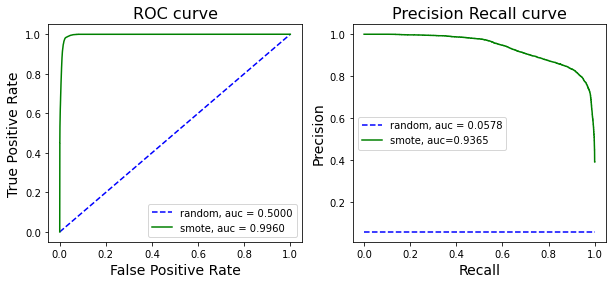

In [22]:
##Create ROC-AUC and PR-AUC curve
generate_curves(MODELS / 'forest_smote_26.sav', df_feature, df_target)

In [23]:
## Find out top 5 most important features using SMOTE method

<Figure size 720x720 with 0 Axes>

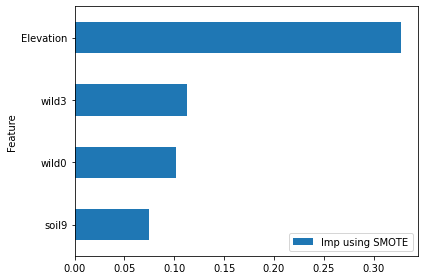

In [24]:
filename = (MODELS / 'forest_smote_26.sav')
loaded_model = pickle.load(open(filename, 'rb'))
var_imp = (pd.Series(loaded_model.steps[1][1].feature_importances_, index=df_feature.columns).nlargest(4))
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Feature', 'Imp using SMOTE']
var_imp_df.set_index('Feature', inplace=True)

plt.figure(figsize=(10, 10))
rcParams.update({'figure.autolayout': True})
var_imp_df.plot(kind='barh').invert_yaxis()
plt.savefig(REPORTS / 'forest26_smote.jpeg', bbox_inches='tight')